In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, optimize, minimize,fminbound
plt.rcParams.update({
    "text.usetex": True,             # Use LaTeX for all text rendering
    "font.family": "serif",          # Use a serif font like Computer Modern
    "font.serif": ["Computer Modern"],
    "font.size": 10,                 # General font size (matches LaTeX \normalsize for 11pt)
    "axes.labelsize": 8,            # Font size for axis labels
    "axes.titlesize": 10,            # Font size for plot titles
    "legend.fontsize": 7,            # Font size for legends
    "xtick.labelsize": 6,            # Font size for x-tick labels
    "ytick.labelsize": 6,            # Font size for y-tick labels
    "axes.linewidth": 0.75,             # Line width for axes
    "lines.linewidth": 0.75,            # Line width for plot lines
    "patch.linewidth": 0.5,           # Line width for patches
    "figure.titlesize": 10
})

39.247345458971374
42.77960655027881
0.005183025591188855
2.5479430221475385
438.46055830454776
0.0002
0.46025651002454365


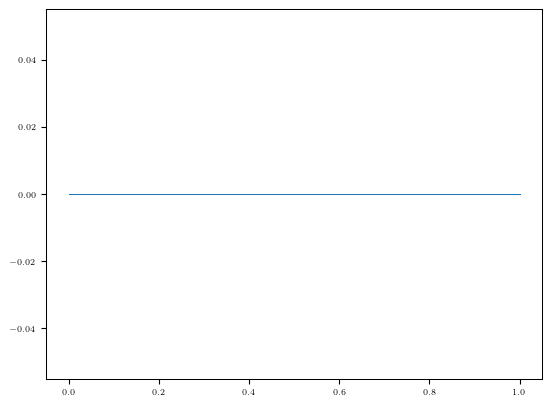

In [9]:
# scalings
L=1e5;g=9.81; m = 80; P_peloton_hat = 200 # Watts
rho = 1.225; A= 0.36;C_d_avg = 0.7
v_hat_peloton = (2*P_peloton_hat/(C_d_avg*rho*A))**(1/3)
print(v_hat_peloton*3.6) #kph
gravity_term = m*g*v_hat_peloton/P_peloton_hat
print(gravity_term)
acceleration_term = m*v_hat_peloton**3/L/P_peloton_hat
print(acceleration_term)
peloton_time = L/v_hat_peloton
print(peloton_time/3600) # hours
energy_scale = P_peloton_hat*peloton_time
print(energy_scale/4184)#kcal
omega = 1
def theta(x):
    return 0.01*np.sin(np.pi*x)*0
lambda_ = 0.25
N_0 = 5
zeta_0_hat = N_0*4
zeta_0 = zeta_0_hat/L
print(zeta_0)
P_lurking = (0.05 + (1-0.05)*np.exp(-lambda_*zeta_0*L/4))/0.7
P_attack = 3.6249
print(P_lurking)
C_d_single=1/0.7
plt.plot(np.linspace(0,1,100), theta(np.linspace(0,1,100)))
def C_d(zeta):
    if zeta > 0:
        return (0.05 + (1-0.05)*np.exp(-zeta*L/4*lambda_))/0.7 # you are inside the peloton
    elif zeta > 0.001:
        return 1/0.7 # you have fallen behind the peloton and you are by yourself
    else:
        return 1/0.7 # you are ahead of the peloton

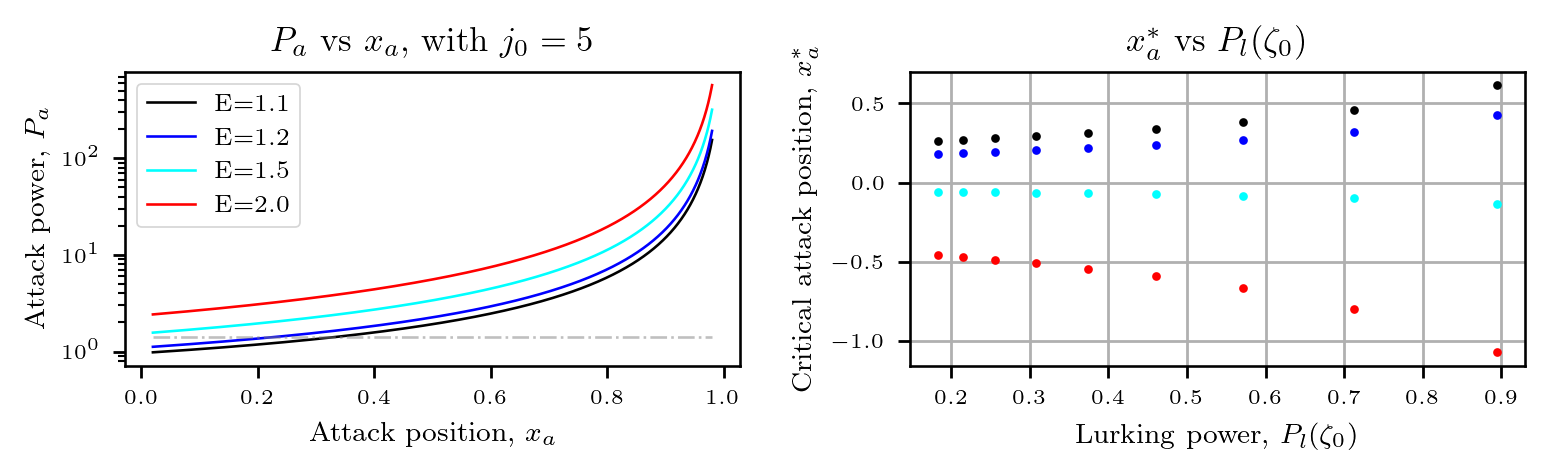

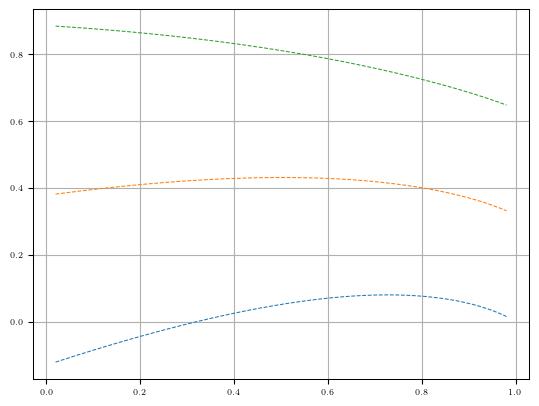

In [10]:
# P_attack(x_attack) to keep the energy expenditure equal to target
E_target = 1.12;C_d_v=1/0.7
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(6.3,2.),dpi=250)
x_attack_vec = np.linspace(0.02, 0.98, 1000)
colors=['black','blue','cyan','red']

position_vec= np.linspace(2,10,9);zeta_0_hat_vec = position_vec*4;zeta_0_vec = zeta_0_hat_vec/L
P_lurking_vec = (0.05 + (1-0.05)*np.exp(-lambda_*zeta_0_vec*L/4))/0.7
j=0
for E_value in [1.1, 1.2,1.5,2.0]:
    P_a_analytical =  ((E_value - P_lurking*(x_attack_vec+zeta_0))/((1-x_attack_vec)/0.7**(1/3)))**(3/2)
    ax[0].semilogy(x_attack_vec,P_a_analytical,label=f'E={E_value}',color=colors[j])
    x_a_critical_vec = (C_d_single-E_value+P_lurking_vec*zeta_0_vec)/(C_d_single - P_lurking_vec)
    ax[1].plot(P_lurking_vec, x_a_critical_vec,'.',label=f'E={E_value}',markersize=3,color=colors[j])
    j+=1
ax[0].legend();#ax[1].legend()
ax[0].plot(x_attack_vec, np.ones_like(x_attack_vec)/0.7, '-.',color='grey', alpha=0.5);
ax[0].set_ylabel('Attack power, $P_a$');ax[0].set_xlabel('Attack position, $x_a$');
ax[1].set_ylabel('Critical attack position, $x_a^*$');ax[1].set_xlabel('Lurking power, $P_l(\zeta_0)$')
ax[0].set_title('$P_a$ vs $x_a$, with $j_0=5$');ax[1].set_title('$x_a^*$ vs $P_l(\zeta_0)$');ax[1].grid(True)
plt.tight_layout()
plt.savefig('power_and_critical_attack_position_flat.pdf')
plt.show()
T_f = (x_attack_vec + zeta_0 
       + (1-x_attack_vec)**(3/2)*C_d_v**(1/2)/(E_target-P_lurking*(x_attack_vec+zeta_0))**(1/2))
plt.plot(x_attack_vec,1-T_f,'--', label='analytical')

prob_crash = ((1-x_attack_vec)**(3/2)*C_d_v**(1/2)/(E_target-P_lurking*x_attack_vec)**(1/2) 
             + (x_attack_vec+zeta_0)*(1-np.exp(-omega*N_0))/(1-np.exp(-omega)))
plt.grid()
beta=0.5
plt.plot(x_attack_vec,(1-T_f)*beta+(1-beta)/prob_crash,'--', label='analytical')
plt.plot(x_attack_vec,1/prob_crash,'--', label='analytical')


/var/folders/wx/hvlspwk90qj6x4ybxggkjycr0000gn/T/ipykernel_24546/2532201213.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.xlabel(r'$\beta$');plt.ylabel(r'Optimal attack position, $x_a^*$');plt.legend();plt.tight_layout()


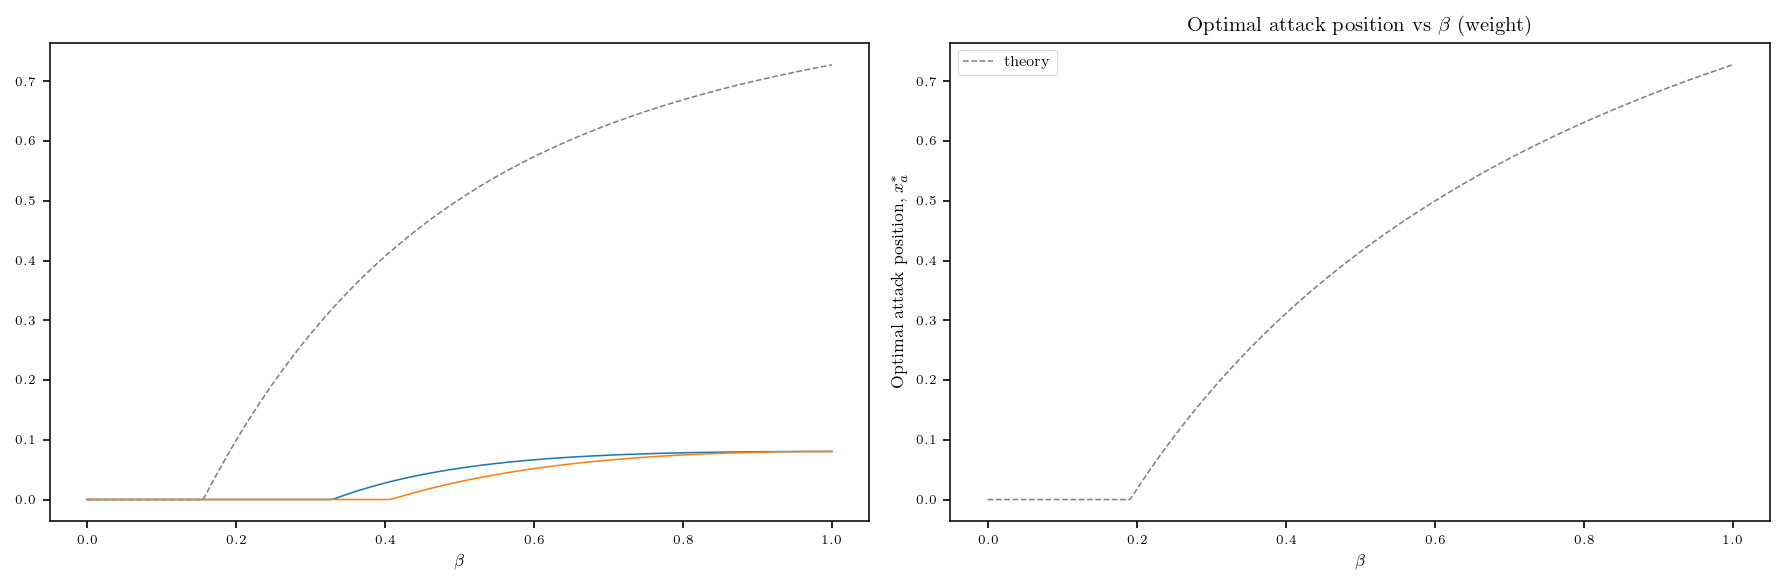

In [11]:
# for each alpha we have to compute the the maximum. 
beta_array = np.linspace(0,1,200)
finishing_time_gap = np.zeros_like(beta_array)
#x_attack_optimal_vec = np.zeros_like(alpha_array)
x_attack_optimal_vec_analytical = np.zeros_like(beta_array)
for j, beta in enumerate(beta_array):
    def metric_analytical(x_a):
        C_d_v = 1/0.7
        P_a_analytical =  ((E_target - P_lurking*(x_a+zeta_0))/((1-x_a)*C_d_v**(1/3)))**(3/2)
        #T_f = x_a + zeta_0 + (1-x_a)/(P_a_analytical/C_d_v)**(1/3)
        T_f = x_a + zeta_0 + (1-x_a)**(3/2)*C_d_v**(1/2)/(E_target - P_lurking*(x_a+zeta_0))**(1/2)
        
        numerator = 1 - T_f
        denominator = ((1-x_a)**(3/2)*C_d_v**(1/2)/(E_target-P_lurking*x_a)**(1/2) + (x_a+zeta_0)*(1-np.exp(-omega*N_0))/(1-np.exp(-omega)))
        #denominator = T_f - x_a-zeta_0 + (x_a+zeta_0)*(1-np.exp(-omega*N_0))/(1-np.exp(-omega))
        return -(numerator*beta+(1-beta)/denominator)
    #plt.plot(x_attack_vec, -metric_analytical(x_attack_vec))
    if j>0: # we sorten the bound using the previous estimate, for faster convergence
        result2  = fminbound(metric_analytical,0, 1)
    else:
        result2  = fminbound(metric_analytical,0,1)
    x_a=result2
    P_a_analytical =  ((E_target - P_lurking*(x_a+zeta_0))/((1-x_a)*C_d_v**(1/3)))**(3/2)
    T_f = x_a + zeta_0 + (1-x_a)**(3/2)*C_d_v**(1/2)/(E_target - P_lurking*(x_a+zeta_0))**(1/2)
    x_attack_optimal_vec_analytical[j] = result2
    finishing_time_gap[j]=1-T_f
fig,ax=plt.subplots(dpi=150,figsize=(12,4),nrows=1,ncols=2)
#plt.semilogx(alpha_array, x_attack_optimal_vec,color='black', label='numerics');plt.grid()
ax[0].plot(beta_array, x_attack_optimal_vec_analytical, '--', color='grey',label='theory')
plt.title(r'Optimal attack position vs $\beta$ (weight)')

plt.xlabel(r'$\beta$');plt.ylabel(r'Optimal attack position, $x_a^*$');plt.legend();plt.tight_layout()
ax[0].plot(beta_array,np.where(finishing_time_gap<0, 0, finishing_time_gap));ax[0].grid()

ax[0].set_xlabel(r'$\beta$');
# for each alpha we have to compute the the maximum. 
beta_array = np.linspace(0,1,200)
finishing_time_gap = np.zeros_like(beta_array)
#x_attack_optimal_vec = np.zeros_like(alpha_array)
x_attack_optimal_vec_analytical = np.zeros_like(beta_array)
for j, beta in enumerate(beta_array):
    def metric_analytical(x_a):
        C_d_v = 1/0.7
        P_a_analytical =  ((E_target - P_lurking*(x_a+zeta_0))/((1-x_a)*C_d_v**(1/3)))**(3/2)
        #T_f = x_a + zeta_0 + (1-x_a)/(P_a_analytical/C_d_v)**(1/3)
        T_f = x_a + zeta_0 + (1-x_a)**(3/2)*C_d_v**(1/2)/(E_target - P_lurking*(x_a+zeta_0))**(1/2)
        
        numerator = 1 - T_f
        denominator = ((1-x_a)**(3/2)*C_d_v**(1/2)/(E_target-P_lurking*x_a)**(1/2) + (x_a+zeta_0)*(1-np.exp(-omega*N_0))/(1-np.exp(-omega)))
        #denominator = T_f - x_a-zeta_0 + (x_a+zeta_0)*(1-np.exp(-omega*N_0))/(1-np.exp(-omega))
        return (-numerator*beta+(1-beta)*denominator)
    #plt.plot(x_attack_vec, -metric_analytical(x_attack_vec))
    if j>0: # we sorten the bound using the previous estimate, for faster convergence
        result2  = fminbound(metric_analytical,0, 1)
    else:
        result2  = fminbound(metric_analytical,0,1)
    x_a=result2
    P_a_analytical =  ((E_target - P_lurking*(x_a+zeta_0))/((1-x_a)*C_d_v**(1/3)))**(3/2)
    T_f = x_a + zeta_0 + (1-x_a)**(3/2)*C_d_v**(1/2)/(E_target - P_lurking*(x_a+zeta_0))**(1/2)
    x_attack_optimal_vec_analytical[j] = result2
    finishing_time_gap[j]=1-T_f
#fig,ax=plt.subplots(dpi=150,figsize=(12,4),nrows=1,ncols=2)
#plt.semilogx(alpha_array, x_attack_optimal_vec,color='black', label='numerics');plt.grid()
plt.plot(beta_array, x_attack_optimal_vec_analytical, '--', color='grey',label='theory')
plt.title(r'Optimal attack position vs $\beta$ (weight)')

plt.xlabel(r'$\beta$');plt.ylabel(r'Optimal attack position, $x_a^*$');plt.legend();plt.tight_layout()
ax[0].plot(beta_array,np.where(finishing_time_gap<0, 0, finishing_time_gap));ax[0].grid()

ax[0].set_xlabel(r'$\beta$');
plt.show()

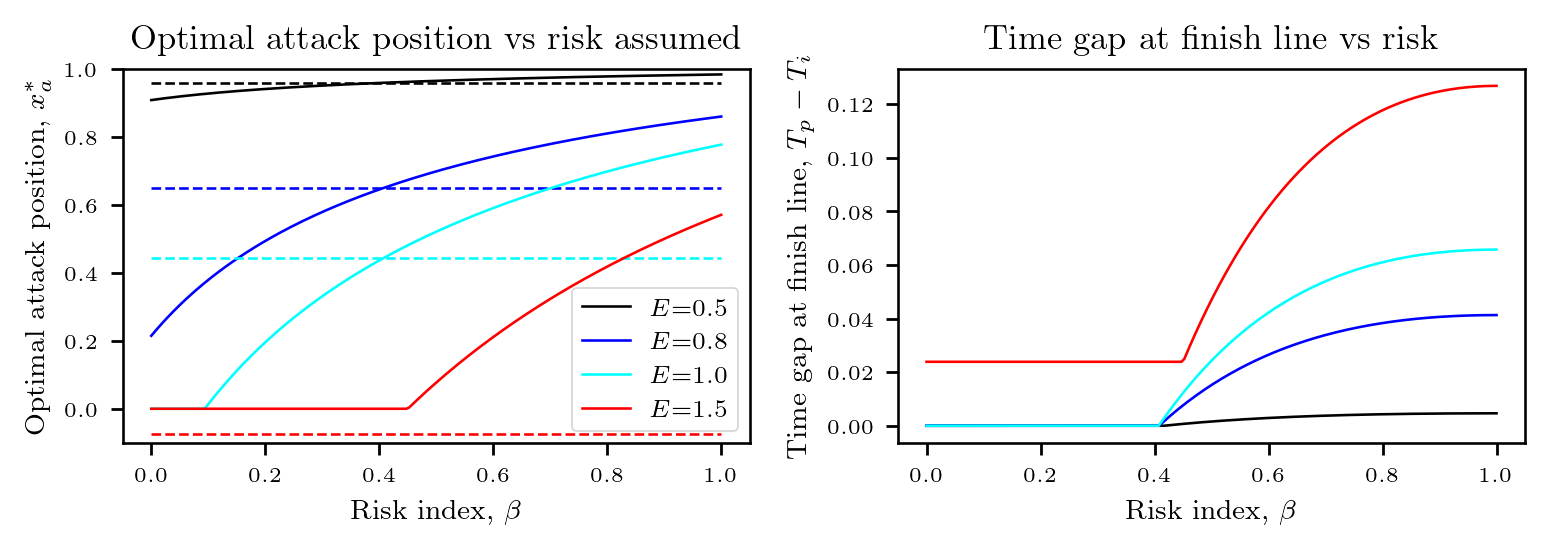

In [12]:
# for each alpha we have to compute the the maximum. 
E_target = 1.12;C_d_v=1/0.7
beta_array = np.linspace(0,1,200)
finishing_time_gap = np.zeros_like(beta_array)
#x_attack_optimal_vec = np.zeros_like(alpha_array)
fig,ax=plt.subplots(dpi=250,figsize=(6.3,2.3),nrows=1,ncols=2)
x_attack_optimal_vec_analytical = np.zeros_like(beta_array);power_vec_analytical= np.zeros_like(beta_array)
k=-1
for E_value in [0.5,0.8, 1.,1.5]:
    k+=1
    for j, beta in enumerate(beta_array):
        def metric_analytical(x_a):
            C_d_v = 1/0.7
            P_a_analytical =  ((E_value - P_lurking*(x_a+zeta_0))/((1-x_a)*C_d_v**(1/3)))**(3/2)
            #T_f = x_a + zeta_0 + (1-x_a)/(P_a_analytical/C_d_v)**(1/3)
            T_f = x_a + zeta_0 + (1-x_a)**(3/2)*C_d_v**(1/2)/(E_value - P_lurking*(x_a+zeta_0))**(1/2)
            
            numerator = 1 - T_f
            denominator = ((1-x_a)**(3/2)*C_d_v**(1/2)/(E_value-P_lurking*x_a)**(1/2) + (x_a+zeta_0)*(1-np.exp(-omega*N_0))/(1-np.exp(-omega)))
            #denominator = T_f - x_a-zeta_0 + (x_a+zeta_0)*(1-np.exp(-omega*N_0))/(1-np.exp(-omega))
            return (-numerator*beta + (1-beta)*denominator)
        #plt.plot(x_attack_vec, -metric_analytical(x_attack_vec))
        if j>0: # we sorten the bound using the previous estimate, for faster convergence
            result2  = fminbound(metric_analytical,0, 1)
        else:
            result2  = fminbound(metric_analytical,0,1)
        x_a=result2
        P_a_analytical =  ((E_value - P_lurking*(x_a+zeta_0))/((1-x_a)*C_d_v**(1/3)))**(3/2)
        power_vec_analytical[j]=P_a_analytical
        T_f = x_a + zeta_0 + (1-x_a)**(3/2)*C_d_v**(1/2)/(E_value - P_lurking*(x_a+zeta_0))**(1/2)
        x_attack_optimal_vec_analytical[j] = result2
        finishing_time_gap[j]=1-T_f

    #plt.semilogx(alpha_array, x_attack_optimal_vec,color='black', label='numerics');plt.grid()
    ax[0].plot(beta_array, x_attack_optimal_vec_analytical,label=fr'$E$={E_value}',color=colors[k])
    ax[0].plot(beta_array,np.ones_like(beta_array)*(C_d_single-E_value+P_lurking*zeta_0)/(C_d_single-P_lurking), '--',color=colors[k])
    ax[1].plot(beta_array,np.where(finishing_time_gap<0, 0, finishing_time_gap),color=colors[k]);
    #ax[2].plot(beta_array, power_vec_analytical,color=colors[k])
#ax[0].grid()
ax[0].set_title(r'Optimal attack position vs risk assumed')
ax[0].set_ylim([-.1,1])
ax[0].set_xlabel(r'Risk index, $\beta$');ax[0].set_ylabel(r'Optimal attack position, $x_a^*$');ax[0].legend()
ax[1].set_title('Time gap at finish line vs risk');ax[1].set_ylabel('Time gap at finish line, $T_p-T_i$')
ax[1].set_xlabel(r'Risk index, $\beta$');
plt.tight_layout()
plt.savefig('new_metric_frole_of_risk_flat.pdf')
plt.show()

In [13]:
# numerical, we need a solver and so on
def compute_metric(x_a, E_target, beta, zeta_0=0.0002):
    def compute_finish_time(x_a, E_target, zeta_0=0.0002):
        def stop_condition(t,state_vec):
            return state_vec[0]-1
        stop_condition.terminal = True
        ic_individual = np.array([-zeta_0,1]);ic_peloton = np.array([0,1])
        ic = np.concatenate([ic_peloton,ic_individual])
        def RHS(t,state):
            x_p = state[0]; x_dot_p = state[1]
            x_i = state[2]; x_dot_i = state[-1]
            zeta = x_p - x_i
            dstatedt=np.zeros_like(state)
            dstatedt[0] = x_dot_p
            dstatedt[1] = 1/acceleration_term*(1/x_dot_p-x_dot_p**2-gravity_term*np.sin(theta(x_p)))
            if x_i<x_a:
                dstatedt[2] = x_dot_p
                dstatedt[-1] = dstatedt[1]
            else:
                if x_i > 1.0001:
                    dstatedt[2] = 0 #we have finished the race
                    dstatedt[-1]= -1/acceleration_term*x_dot_i
                else:
                    dstatedt[2] = x_dot_i
                    dstatedt[-1] = 1/acceleration_term*(P_attack/x_dot_i-C_d(0)*x_dot_i**2-gravity_term*np.sin(theta(x_i)))
            return dstatedt
        t_span = (0,3)
        solution=solve_ivp(RHS, t_span,ic, 
                  events=stop_condition,method='RK45', atol = 1e-9)
        x_p=solution.y[0,:];x_dot_p=solution.y[1,:];
        x_i=solution.y[2,:];x_dot_i=solution.y[-1,:]
        t_eval = solution.t;
        T_finish_rider = t_eval[np.argmin(abs(x_i-1))]; T_finish_peloton = t_eval[-1]
        x_ddot_i = np.gradient(x_dot_i, t_eval);x_ddot_p = np.gradient(x_dot_p, t_eval)
        zeta = -(x_i-x_p)
        C_d_vect = np.vectorize(C_d)
        P_i = x_dot_i*(acceleration_term*x_ddot_i+gravity_term*np.sin(theta(x_i))+C_d_vect(zeta)*x_dot_i**2)
        P_p = x_dot_p*(acceleration_term*x_ddot_p+gravity_term*np.sin(theta(x_p))+x_dot_p**2)
        return T_finish_rider, zeta,t_eval
    T_finish,zeta,t_eval = compute_finish_time(x_a,E_target)
    def compute_probability_crashing(x_a):
        return np.trapz(np.where(zeta<0,1,(1-np.exp(-omega*N_0))/(1-np.exp(-omega))),t_eval)
    return (1-T_finish)*beta+(1-beta)*compute_probability_crashing(x_a)
compute_metric(0.5, 1.2, 0.5)

0.7090266421463018